In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/suicidal-mental-health-dataset/mental-health.csv


In [2]:
from keras_hub.tokenizers import WordPieceTokenizer, compute_word_piece_vocabulary

In [3]:
import tensorflow as tf
import keras
from keras import layers, optimizers

In [4]:
df = pd.read_csv('/kaggle/input/suicidal-mental-health-dataset/mental-health.csv')

In [5]:
df.head()

,text,label
0,I recently went through a breakup and she said...,depression
1,"I do not know how to navigate these feelings, ...",depression
2,"So I have been with my bf for 5 months , and h...",depression
3,I am so exhausted of this. Just when I think I...,SuicideWatch
4,I have been severly bullied since i was 5 till...,depression


In [6]:
df['label'] = df['label'].str.replace('SuicideWatch', 'suicidal')
df['label'] = df['label'].str.lower()

In [7]:
binarized = []
for label in df['label']:
    if label == 'suicidal':
        binarized.append(1)
    else:
        binarized.append(0)

binarized = pd.Series(binarized, name='label')
df = df.drop('label', axis=1)
df = pd.concat([df, binarized], axis=1)

In [8]:
df.head()

,text,label
0,I recently went through a breakup and she said...,0
1,"I do not know how to navigate these feelings, ...",0
2,"So I have been with my bf for 5 months , and h...",0
3,I am so exhausted of this. Just when I think I...,1
4,I have been severly bullied since i was 5 till...,0


In [9]:
df.isna().any().any()

False

In [10]:
from sklearn.model_selection import train_test_split

In [11]:
train_df, other = train_test_split(
    df,
    test_size = 0.9,
    random_state = 9700,
    shuffle = True,
    stratify = df['label'],
)

In [12]:
val_df, test_df = train_test_split(
    other,
    test_size = 0.5,
    random_state = 9700,
    shuffle = True,
    stratify = other['label'],
)

In [13]:
with tf.device('/GPU:0'):
    train_dataset = tf.data.Dataset.from_tensor_slices(
        (train_df['text'].values, train_df['label'].values)
    )

In [14]:
val_dataset = tf.data.Dataset.from_tensor_slices(
    (val_df['text'].values, val_df['label'].values)
)

In [15]:
test_dataset = tf.data.Dataset.from_tensor_slices(
    (test_df['text'].values, test_df['label'].values)
)

In [16]:
# convert the text to lowercase
train_dataset = train_dataset.map(lambda text, label: (tf.strings.lower(text), label))
val_dataset = val_dataset.map(lambda text, label: (tf.strings.lower(text), label))
test_dataset = test_dataset.map(lambda text, label: (tf.strings.lower(text), label))

In [17]:
BITCH_SIZE = 64
auto = tf.data.AUTOTUNE

In [18]:
train_dataset = train_dataset.batch(BITCH_SIZE).prefetch(auto)
val_dataset = val_dataset.batch(BITCH_SIZE).prefetch(auto)
test_dataset = test_dataset.batch(BITCH_SIZE).prefetch(auto)

In [19]:
for text_batch, label_batch in train_dataset.take(1):
    for i in range(3):
        print(f"{text_batch.numpy()[i]}\n{label_batch.numpy()[i]}\n")

b"i am trying to get into mtg because my partner is into it and i want to do things that they like, but the game makes me so sad for some reason. like i bought a bulk box and i just got a bunch of common boring cards and i cannot stop crying over it?? i wanted really cool cards like my partner has and it is just all junky cards and i feel so let down.this caused a fight with my partner because i was being extremely negative. we have been having a lot of fights recently that are always caused by my negativity. it just gets really bad at night. i do not know. i am sick of crying and i have a doctor's appointment tomorrow and i might just not go. i feel too shitty to do anything. i have been crying over magic cards on and off all day"
0

b'i live in a semi-tropical area where plants take over everything, but i feel like i have this horticultural curse that reflects on my life in general. i have tried to grow plants for years, even building wooden planters, but then once the plants sprout 

In [20]:
#Calculate Vocabulary Size
vocabulary = set()
train_df['text'].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

20817


In [21]:
reserved_tokens = ["[PAD]", "[UNK]"]

In [22]:
def train_word_piece(ds, vocab_size, reserved_tokens):
    word_piece_ds = ds.unbatch().map(lambda x, y: x)
    vocab = compute_word_piece_vocabulary(
        word_piece_ds.batch(1000).prefetch(2),
        vocabulary_size=vocabulary_size,
        reserved_tokens=reserved_tokens,
    )
    return vocab

In [23]:
vocab = train_word_piece(train_dataset, vocabulary_size, reserved_tokens)

In [24]:
print(f'Tokens: {vocab[36:54]}')

Tokens: ['_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p']


In [25]:
train_df['text'].apply(lambda x: len(x.split(" "))).describe()

count    2036.000000
mean      164.407171
std       181.896090
min         1.000000
25%        53.000000
50%       107.000000
75%       210.250000
max      2364.000000
Name: text, dtype: float64

In [26]:
MAX_SEQLEN = 256

In [27]:
tokenizer = WordPieceTokenizer(
    vocabulary = vocab,
    lowercase = False,
    sequence_length = MAX_SEQLEN,
)

In [28]:
input_sentence_ex = train_dataset.take(1).get_single_element()[0][0]
input_tokens_ex = tokenizer(input_sentence_ex)

print("Sentence: ", input_sentence_ex)
print("Tokens: ", input_tokens_ex)
print("Recovered text after detokenizing: ", tokenizer.detokenize(input_tokens_ex))

Sentence:  tf.Tensor(b"i am trying to get into mtg because my partner is into it and i want to do things that they like, but the game makes me so sad for some reason. like i bought a bulk box and i just got a bunch of common boring cards and i cannot stop crying over it?? i wanted really cool cards like my partner has and it is just all junky cards and i feel so let down.this caused a fight with my partner because i was being extremely negative. we have been having a lot of fights recently that are always caused by my negativity. it just gets really bad at night. i do not know. i am sick of crying and i have a doctor's appointment tomorrow and i might just not go. i feel too shitty to do anything. i have been crying over magic cards on and off all day", shape=(), dtype=string)
Tokens:  tf.Tensor(
[  46   71  208   66  106  214   50  315  501  100   68  704   73  214
   72   67   46   90   66   77  152   78  112   86   13   80   69 1332
  274   76   84  291   82  155  299   15   86   46

In [29]:
def format_dataset(sentence, label):
    sentence = tokenizer(sentence)
    return ({"input_ids": sentence}, label)

In [30]:
def make_dataset(dataset):
    dataset = dataset.map(format_dataset, num_parallel_calls=tf.data.AUTOTUNE)
    return dataset.shuffle(BITCH_SIZE * 8).prefetch(16).cache()

In [31]:
train_dataset = make_dataset(train_dataset)
val_dataset = make_dataset(val_dataset)
test_dataset = make_dataset(test_dataset)

In [32]:
from keras_hub.layers import TokenAndPositionEmbedding, FNetEncoder

In [33]:
EMBED_DIM = 128
INTERMEDIATE_DIM = 512

In [34]:
def FentTweaker(intermediate_dim, second_layer, third_layer, rate, lr):
    input_ids = keras.Input(shape=(None,), dtype="int64", name="input_ids")
    x = TokenAndPositionEmbedding(
        vocabulary_size=vocabulary_size,
        sequence_length=MAX_SEQLEN,
        embedding_dim=EMBED_DIM,
        mask_zero=True,
    )(input_ids)
    x = FNetEncoder(intermediate_dim=intermediate_dim)(inputs=x)
    if second_layer: x = FNetEncoder(intermediate_dim=intermediate_dim)(inputs=x)
    if third_layer: x = FNetEncoder(intermediate_dim=intermediate_dim)(inputs=x)
    
    x = keras.layers.GlobalAveragePooling1D()(x)
    x = keras.layers.Dropout(rate)(x)
    outputs = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(input_ids, outputs, name="FentTweaker9750")
    model.compile(
        optimizer = optimizers.Adam(learning_rate=lr),
        loss = "binary_crossentropy",
        metrics = ["accuracy"]
    )
    return model

In [35]:
import keras_tuner as kt

In [36]:
def build_model(hp):
    intermediate_dim = hp.Choice("intermediate_dim", [256, 512, 1024])
    second_layer = hp.Boolean("second_layer")
    third_layer = hp.Boolean("third_layer")
    rate = hp.Float("rate", min_value=0.1, max_value=0.2, step=0.05, sampling="linear")
    lr = hp.Float("lr", min_value=1e-4, max_value=1e-3, step=10, sampling="log")

    model = FentTweaker(intermediate_dim, second_layer, third_layer, rate, lr)
    return model
    

In [37]:
build_model(kt.HyperParameters())

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'f_net_encoder' (of type FNetEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


<Functional name=FentTweaker9750, built=True>

In [38]:
tuner = kt.GridSearch(
    hypermodel = build_model,
    objective = "val_loss",
    overwrite = True,
    directory = "FentTweaker",
    project_name = "9750"
    
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'f_net_encoder_1' (of type FNetEncoder) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


In [39]:
tuner.search_space_summary()

Search space summary
Default search space size: 5
intermediate_dim (Choice)
{'default': 256, 'conditions': [], 'values': [256, 512, 1024], 'ordered': True}
second_layer (Boolean)
{'default': False, 'conditions': []}
third_layer (Boolean)
{'default': False, 'conditions': []}
rate (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.2, 'step': 0.05, 'sampling': 'linear'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.001, 'step': 10, 'sampling': 'log'}


In [40]:
tuner.search(train_dataset, epochs=7, validation_data=val_dataset)

Trial 72 Complete [00h 00m 38s]
val_loss: 0.6078583002090454

Best val_loss So Far: 0.6004276871681213
Total elapsed time: 00h 27m 22s


In [47]:
best_model = tuner.get_best_models()[0]

In [48]:
best_model.summary()

Model: "FentTweaker9750"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_ids (InputLayer)               │ (None, None)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding         │ (None, None, 128)           │       2,697,344 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ f_net_encoder (FNetEncoder)          │ (None, None, 128)           │          66,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ f_net_encoder_1 (FNetEncoder)        │ (None, None, 128)           │          66,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,830,337 (10.80 MB)

 Trainable params: 2,830,337 (10.80 MB)

 Non-trainable params: 0 (0.00 B)

In [49]:
callbacks = keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=1,
    mode="auto",
    restore_best_weights=True,
    start_from_epoch=2,
)

In [50]:
history = best_model.fit(train_dataset, epochs=10, validation_data=val_dataset, callbacks=[callbacks])

Epoch 1/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 182ms/step - accuracy: 0.8477 - loss: 0.3834 - val_accuracy: 0.6696 - val_loss: 0.6560
Epoch 2/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9326 - loss: 0.2458 - val_accuracy: 0.6636 - val_loss: 0.7391
Epoch 3/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - accuracy: 0.9398 - loss: 0.1986 - val_accuracy: 0.6664 - val_loss: 0.7672
Epoch 4/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9090 - loss: 0.2440 - val_accuracy: 0.6330 - val_loss: 0.8816
Epoch 5/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9493 - loss: 0.1693 - val_accuracy: 0.5513 - val_loss: 1.3530
Epoch 6/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8717 - loss: 0.2789 - val_accuracy: 0.6419 - val_loss: 0.7435
Epoch 7/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.8968 - loss: 0.2383 - val_accuracy: 0.6760 - val_loss: 0.7249
Epoch 8/10
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.9867 - loss: 0.0622 - val_accuracy: 0.6679 -

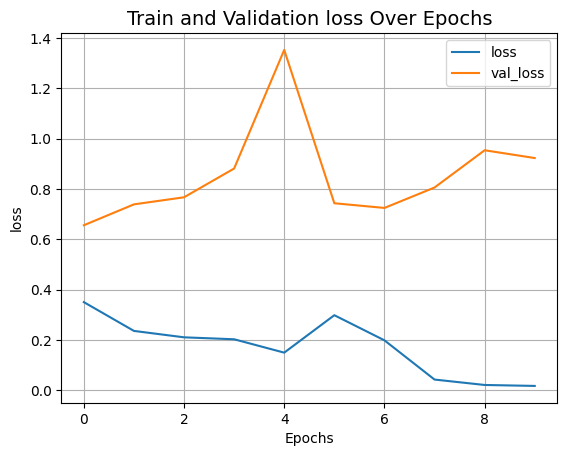

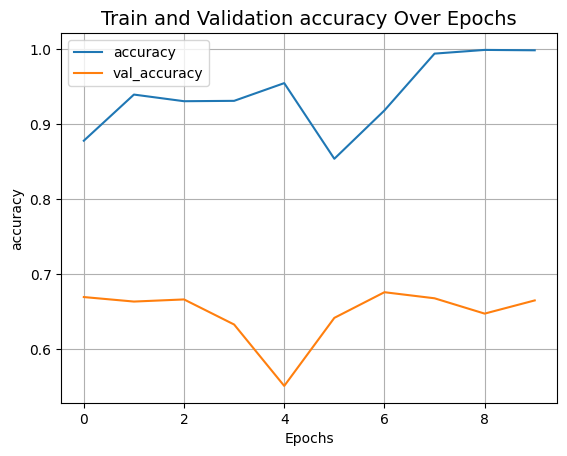

In [51]:
import matplotlib.pyplot as plt

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()


plot_result("loss")
plot_result("accuracy")

In [52]:
best_model.evaluate(test_dataset)

144/144 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.6748 - loss: 0.7336


[0.7212633490562439, 0.6762331128120422]